# 上海交通大学BI908《生物医学图像处理》 Lab 2 @
### SJTU BI908《biomedical image processing》 Lab 2@
-----


## 学生信息（Student information）：
`姓名（Name）：`

`学号 （ID）：`

-----
## 作业内容（Contents）：

### 1 读取图片

(-0.5, 383.5, 511.5, -0.5)

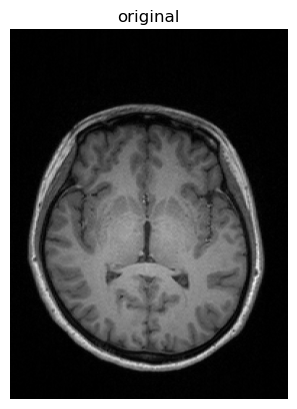

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

img = np.fromfile("OneSlice.dat", dtype="uint16") 
img.shape = (384, 512)
img = img.T

row = 512
col = 384

fig = plt.figure()
plt.imshow(abs(img), cmap='gray') 
plt.title("original")
plt.axis('off')  

In [64]:
def display(original, changed): 
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original, cmap=plt.cm.gray)
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[1].imshow(changed, cmap=plt.cm.gray)
    axes[1].set_title('Change')
    axes[1].axis('off') 
    plt.tight_layout()

In [65]:
def erosion(img, row, col, size):
    imgEro = np.zeros((row, col))
    kernel = np.ones((size,size))
    tmp = np.zeros((size,size))
    half = size // 2
    for i in range(half, row-half):                          #腐蚀
        for j in range (half, col-half):
            tmp = img[i-half:i+half+1, j-half:j+half+1] 
            imgEro[i][j] = np.min(tmp)
    return imgEro

In [66]:
def explotion(img, row, col, size):
    imgExp = np.zeros((row, col))
    kernel = np.ones((size,size))
    tmp = np.zeros((size,size))
    half = size // 2
    for i in range(half, row-half):                          #膨胀
        for j in range (half, col-half):
            tmp = img[i-half:i+half+1, j-half:j+half+1] 
            imgExp[i][j] = np.max(tmp)
    return imgExp

虽然我直接调包了，但是腐蚀和膨胀函数还是写了的，但是自己写的函数的运行效率太低了，就直接调包了

### 2 提取边界，与空间滤波相比

In [67]:
size = 3
kernel = np.ones((size, size), np.uint8) 

eroded = cv2.erode(img, kernel, iterations=1)
dilated = cv2.dilate(img, kernel, iterations=1)

ImgEdge = dilated - eroded

In [68]:
from scipy.signal import convolve2d
sobelx = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])   #x掩膜
sobely = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])   #y掩膜
filterEdgeX = abs(convolve2d(img, sobelx, mode='same', boundary='fill', fillvalue=0))
filterEdgeY = abs(convolve2d(img, sobely, mode='same', boundary='fill', fillvalue=0))
filterEdge = np.clip(filterEdgeX+filterEdgeY, 0, None)

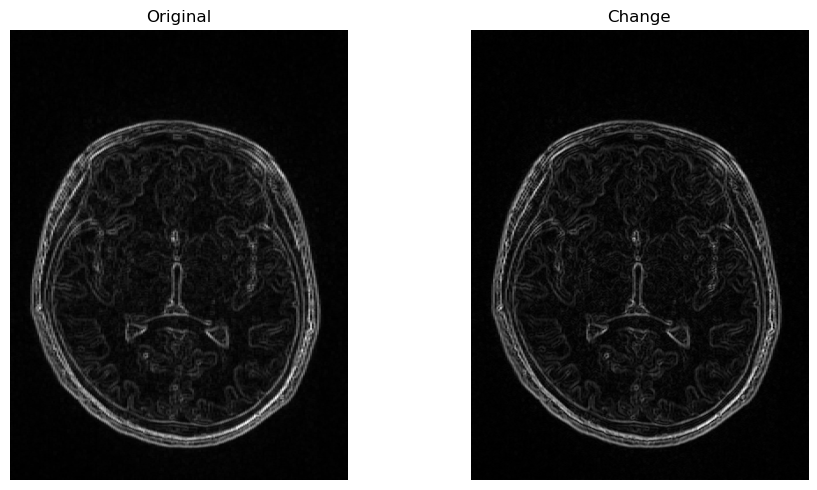

In [69]:
display(ImgEdge, filterEdge)

忽略图题，左边是形态学边界提取，右边是sobel滤波后的梯度图像，结构元使用3\*3的大小，使用膨胀的图像减去腐蚀的图像，其实是形态学梯度处理  
形态学处理能突出更多细节（脑组织中央边界灰度更高了），边缘较粗，对噪声的抵抗力更强；边缘更加连续和平滑（脑组织中央的部分）  
空间滤波的边界对噪声更敏感，虽然这张图看不出来；边界更加离散和尖锐，边缘较细

### 3 图像增强

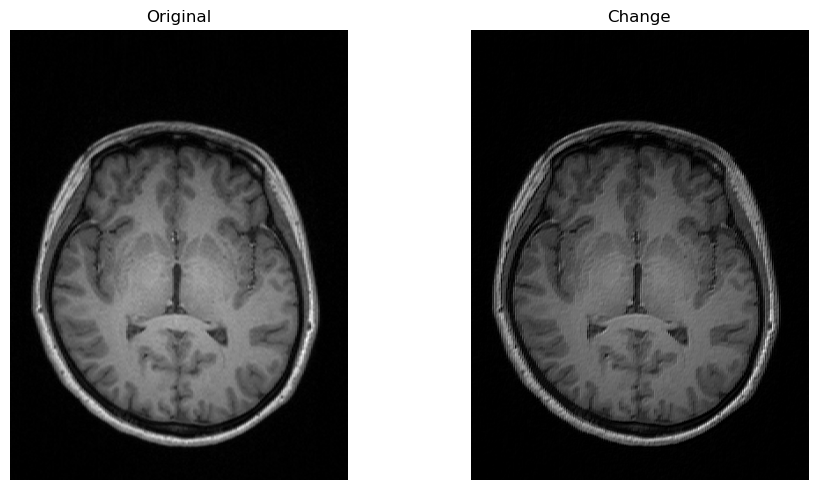

In [70]:
import cv2
size = 3
kernel = np.ones((size,size), np.uint8)

# 1. 开运算，去除噪点
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# 2. 闭运算，填充小孔
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

# 3. 顶帽变换突出亮细节
size = 2
kerne2 = np.ones((size,size), np.uint8)
tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kerne2)

# 4. 底帽变换突出暗细节
blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kerne2)

# 5. 将顶帽和底帽结果与原图结合
enhanced = cv2.add(closing, tophat)
enhanced = cv2.subtract(enhanced, blackhat)

display(img, enhanced)

左边是原图，右边是增强后的图  
这个算法先使用开运算去除了图像中的噪点，具体表现在脑组织中的小黑点没了；然后用闭运算将去噪过程中产生的小缺口进行修补  
接着使用顶帽变换，得到亮细节增强的图像；最后求底帽变换，得到暗细节，将顶帽得到的图像减去暗细节，加大图像的明暗细节对比度  
最终的结果相比原图去掉了噪声而没有使图像变得过于模糊，而且脑组织的暗细节和亮细节对比更加明显  
中间改变了kernel_size，不然就是白做($f\circ b = (f\circ b)\circ b$，换成$\cdot$也一样)

### 4 头骨分割

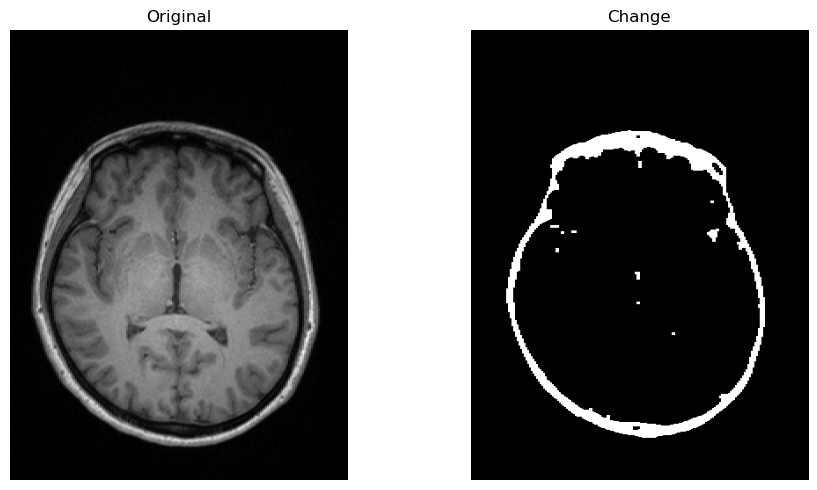

In [71]:
img1 = cv2.convertScaleAbs(img)

# 1. 开闭运算去除噪声
size = 3
kernel1 = np.ones((size,size), np.uint8)
opening = cv2.morphologyEx(img1, cv2.MORPH_OPEN, kernel1)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel1)
#display(img, closing)

# 2. 阈值变换获取骨头之外的
ret, thresh1 = cv2.threshold(img, 113, 255, cv2.THRESH_BINARY)
#display(img, thresh1)

# 3. 闭运算平滑脑组织
size = 3
kernel2 = np.ones((size,size), np.uint8)
closing2 = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, kernel2)
#display(img, closing2)

# 4. 开运算消除毛刺
size = 3
kernel3 = np.ones((size,size), np.uint8)
opening2 = cv2.morphologyEx(closing2, cv2.MORPH_OPEN, kernel3)
#display(img, opening2)

# 5. 反转灰度得到头骨轮廓
skull = 255 - opening2
#display(img, skull)

# 6. 这是背景，把skull变黑，得到头的轮廓，再用一个全亮的图减去头的轮廓得到背景
size = 25
kernel4 = np.ones((size,size), np.uint8)
skull1 = cv2.morphologyEx(skull, cv2.MORPH_OPEN, kernel4)
background = np.ones((row, col)) * 255 - skull1
#display(img, background)

# 7. skull加上背景
skull = background + skull
skull = np.array(skull / 65536 * 255)   #scale到255
skull = skull.astype(np.uint8)
display(img, skull)

In [72]:
def get_largest_connected_component(grayImg):
    # 二值化
    _, binary = cv2.threshold(grayImg, 0, 255, cv2.THRESH_BINARY)
    # 标记连通分量
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)
    
    # 获取最大连通分量
    largestLabel = 1 
    largestArea = stats[1][cv2.CC_STAT_AREA]  
    
    for label in range(2, num_labels):
        area = stats[label][cv2.CC_STAT_AREA]
        if area > largestArea:
            largestArea = area
            largestLabel = label
            
    largest = grayImg
    largest[labels == largestLabel] = 255
    return largest

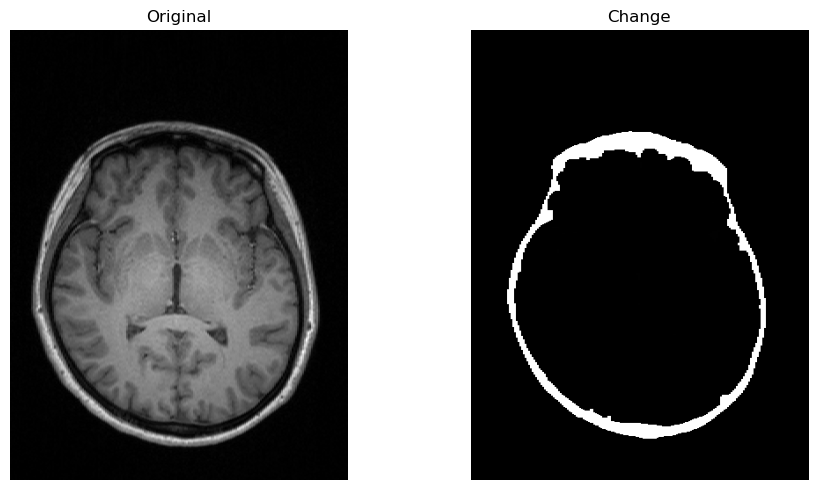

In [73]:
# 8. 提取连通分量，去除中间的噪点
onlySkull = get_largest_connected_component(skull)
#display(img, onlySkull)

# 9. 闭运算闭合缺点
size = 6
kernel5 = np.ones((size,size), np.uint8)
closingSkull = cv2.morphologyEx(onlySkull, cv2.MORPH_CLOSE, kernel5)
display(img, closingSkull)

头骨分割的效果一般，很多毛刺我去除不掉，而且有些地方太细了看起来不是很正常